In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("SPY.csv", parse_dates=[0])

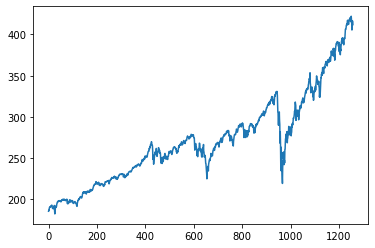

In [3]:
plt.plot(df["Adj Close"])

In [4]:
df["Close diff"] = df["Close"] - df["Adj Close"]

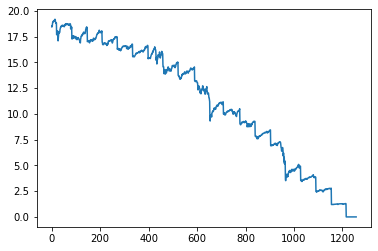

In [5]:
plt.plot(df["Close diff"])

In [6]:
df["Close diff"].max()

19.189468000000005

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close diff
0,2016-05-19,204.059998,204.539993,202.779999,204.199997,185.748718,115430500,18.451279
1,2016-05-20,204.919998,206.100006,204.860001,205.490005,186.922195,104990400,18.567810
2,2016-05-23,205.509995,205.839996,204.990005,205.210007,186.667496,58682600,18.542511
3,2016-05-24,206.169998,208.240005,206.139999,207.869995,189.087112,93537800,18.782883
4,2016-05-25,208.669998,209.770004,207.869995,209.279999,190.369705,76621400,18.910294


In [8]:
df["Close diff"] = df["Adj Close"].pct_change()

<AxesSubplot:xlabel='Close diff', ylabel='Density'>

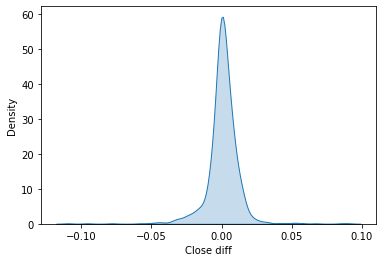

In [9]:
sns.kdeplot(data=df, x="Close diff", shade=True)

In [10]:
df["Close diff"].describe()

count    1257.000000
mean        0.000704
std         0.011838
min        -0.109424
25%        -0.002783
50%         0.000741
75%         0.005583
max         0.090603
Name: Close diff, dtype: float64

In [11]:
df["Close diff"].mean()*252

0.1774967639488196

In [12]:
df2 = df.copy()

In [13]:
df2["year"] = df2["Date"].dt.strftime('%Y')

In [14]:
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close diff,year
0,2016-05-19,204.059998,204.539993,202.779999,204.199997,185.748718,115430500,NaN,2016
1,2016-05-20,204.919998,206.100006,204.860001,205.490005,186.922195,104990400,0.006318,2016
2,2016-05-23,205.509995,205.839996,204.990005,205.210007,186.667496,58682600,-0.001363,2016
3,2016-05-24,206.169998,208.240005,206.139999,207.869995,189.087112,93537800,0.012962,2016
4,2016-05-25,208.669998,209.770004,207.869995,209.279999,190.369705,76621400,0.006783,2016


In [15]:
df2.groupby(by="year").count()

,Date,Open,High,Low,Close,Adj Close,Volume,Close diff
year,,,,,,,,
2016,157,157,157,157,157,157,157,156
2017,251,251,251,251,251,251,251,251
2018,251,251,251,251,251,251,251,251
2019,252,252,252,252,252,252,252,252
2020,253,253,253,253,253,253,253,253
2021,94,94,94,94,94,94,94,94


In [16]:
daily_return = df["Close diff"].mean()
sigma = df["Close diff"].std()
skew = df2["Close diff"].skew()
exces_kurtosis = df2["Close diff"].kurtosis()-3
params = (daily_return, sigma, skew,exces_kurtosis)

In [17]:
n_year = len(df.index)//5
return_pa = ((1+daily_return) ** n_year)-1
sigma_pa = sigma * np.sqrt(n_year)

In [18]:
sigma_pa, return_pa

(0.18754946729855523, 0.19330906967878758)

In [19]:
from scipy import stats as st

In [20]:
confidence = st.norm.ppf(.975)

In [21]:
#VaRRETURN SPACE= S√N * (-1,96 + 0,474 * μ1 / √N – 0,0687 * μ2 / N + 0,146 * μ1^2 / N) – 0,5S^2N
#VEV = √(confidence^2 – 2* VaRRETURN SPACE) -1.96 / √T

In [22]:
VARS = []
for holding in range(1,6):
    VAR_1Y = sigma * np.sqrt(n_year * holding) * (-confidence + 0.474 * skew / np.sqrt(n_year * holding) 
                                              - 0.0687 * exces_kurtosis / n_year
                                    + 0.146 * skew ** 2 / (n_year * holding)) - 0.5 * sigma ** 2 * n_year * holding
    VARS.append(VAR_1Y)

In [23]:
VARS

[-0.39042199230265795,
 -0.5606233182968299,
 -0.6953088012967453,
 -0.8116121915595736,
 -0.9161690413452657]

In [24]:
VEV = []
for position, val in enumerate(VARS):
    VEV_calc = (np.sqrt(confidence ** 2 - 2 * val) - confidence)/ np.sqrt(position + 1)
    VEV.append(VEV_calc)

In [25]:
VARS, VEV

([-0.39042199230265795,
  -0.5606233182968299,
  -0.6953088012967453,
  -0.8116121915595736,
  -0.9161690413452657],
 [0.18999015573816136,
  0.1893271836754602,
  0.18902983240379562,
  0.18885110144066974,
  0.1887283128269403])

In [26]:
#Calculate scenarios
#Unfavourable @ -10 percentile, moderate @ 50 percenile, favourable @90 percentile
#moderate = Exp [ M1*N - sigma * skew/6 – 0.5*sigma²N]

In [228]:
years = 0.5
initial_investment = 10000
monthly_investment = 0
monthly_trading_days = 21

performance = pd.DataFrame(data= np.arange(0,years * 12 + 1) * monthly_trading_days, index=np.arange(0,years * 12 + 1), columns=["trading days"])

In [50]:
#colNames = performance.columns.to_list() + ["unfavorable","moderate","favorable"]

In [51]:
#performance = performance.reindex(columns=colNames)

In [229]:
performance["day_mean"]=daily_return
performance["sigma"] = sigma
performance["sigma_period"] = sigma * np.sqrt(performance["trading days"])
performance["skew"] = skew
performance["exc_kurtosis"] = exces_kurtosis
performance["unfavorable_prob"] = 10
performance["moderate_prob"] = 50
performance["favorable_prob"] = 90

In [191]:
def scenario_calc(days, day_mean, sigma, skew, exc_kurt, confidence):
    '''
    days= trading days in the period
    day_mean = historical daily return
    sigma = historical daily standard deviation
    skew = historical daily skeweness
    exc_kurt = excess kurtosis (excess over 3)
    confidence = percentile 0-100
    '''
    
    #calculate z-scores
    if days == 0:
        return 1
    else:
        z = st.norm.ppf(confidence / 100)
        z1 = (z**2 - 1) / 6
        z2 = (z**3 - 3 * z) / 24
        z3 = (2 * z**3 - 5* z) / 36

        #calculate return over period
        ret = np.exp((day_mean * days) + sigma * np.sqrt(days) * (z + z1 * skew / np.sqrt(days) + z2 * exc_kurt / days
                                                         + z3 * skew**2 / days) - (0.5 * sigma**2 * days))
        return ret

In [192]:
m = 0.0003389
n = 1280
sigma = 0.01224357
skew = -0.351143435
ekurt = 3.528503383
scenario_calc(n, m, sigma, skew, ekurt, 50)

1.4029390218336037

In [230]:
performance["moderate"] = performance[["trading days","day_mean","sigma","skew","exc_kurtosis", "moderate_prob"]].apply(lambda performance: scenario_calc(performance["trading days"], performance["day_mean"],performance["sigma"],performance["skew"], performance["exc_kurtosis"], performance["moderate_prob"]), axis=1)
performance["unfavorable"] = performance[["trading days","day_mean","sigma","skew","exc_kurtosis", "unfavorable_prob"]].apply(lambda performance: scenario_calc(performance["trading days"], performance["day_mean"],performance["sigma"],performance["skew"], performance["exc_kurtosis"], performance["unfavorable_prob"]), axis=1)
performance["favorable"] = performance[["trading days","day_mean","sigma","skew","exc_kurtosis", "favorable_prob"]].apply(lambda performance: scenario_calc(performance["trading days"], performance["day_mean"],performance["sigma"],performance["skew"], performance["exc_kurtosis"], performance["favorable_prob"]), axis=1)

In [231]:
performance

,trading days,day_mean,sigma,sigma_period,skew,exc_kurtosis,unfavorable_prob,moderate_prob,favorable_prob,moderate,unfavorable,favorable
0.0,0.0,0.000704,0.012244,0.000000,-0.351143,15.633505,10,50,90,1.000000,1.000000,1.000000
1.0,21.0,0.000704,0.012244,0.056107,-0.351143,15.633505,10,50,90,1.014031,0.945446,1.085036
2.0,42.0,0.000704,0.012244,0.079347,-0.351143,15.633505,10,50,90,1.027523,0.929082,1.133723
3.0,63.0,0.000704,0.012244,0.097180,-0.351143,15.633505,10,50,90,1.041195,0.919808,1.175829
4.0,84.0,0.000704,0.012244,0.112214,-0.351143,15.633505,10,50,90,1.055048,0.914046,1.214939
5.0,105.0,0.000704,0.012244,0.125459,-0.351143,15.633505,10,50,90,1.069085,0.910472,1.252380
6.0,126.0,0.000704,0.012244,0.137434,-0.351143,15.633505,10,50,90,1.083310,0.908428,1.288821


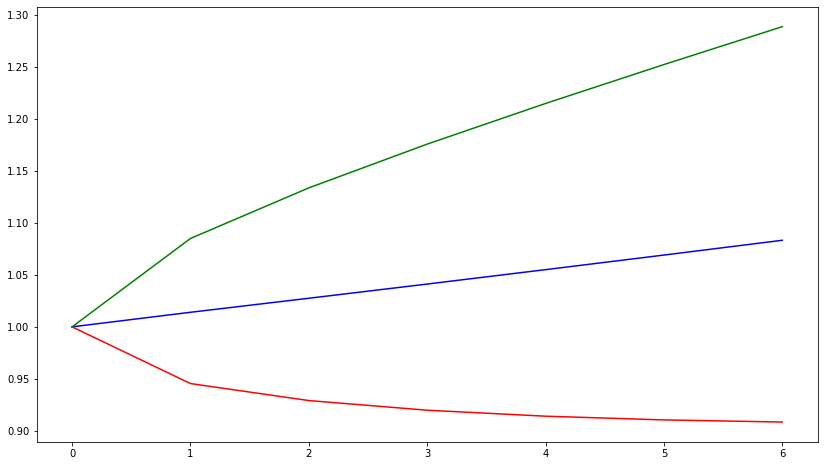

In [232]:
fig, ax = plt.subplots(figsize=(14,8))
ax = plt.plot(performance["moderate"], color="blue")
ax = plt.plot(performance["unfavorable"], color="red")
ax = plt.plot(performance["favorable"], color="green")

In [233]:
money_perf = performance[["unfavorable","moderate","favorable"]].copy()

In [234]:
money_perf

,unfavorable,moderate,favorable
0.0,1.000000,1.000000,1.000000
1.0,0.945446,1.014031,1.085036
2.0,0.929082,1.027523,1.133723
3.0,0.919808,1.041195,1.175829
4.0,0.914046,1.055048,1.214939
5.0,0.910472,1.069085,1.252380
6.0,0.908428,1.083310,1.288821


In [235]:
initial_investment = 150000

#money_perf["shift"] = money_perf["unfavorable"].shift(1, fill_value=1)
money_perf["unfav_bootstrap"] = money_perf["unfavorable"] / money_perf["unfavorable"].shift(1, fill_value=1)
money_perf["moderate_bootstrap"] = money_perf["moderate"] / money_perf["moderate"].shift(1, fill_value=1)
money_perf["fav_bootstrap"] = money_perf["favorable"] / money_perf["favorable"].shift(1, fill_value=1)

In [237]:
money_perf

,unfavorable,moderate,favorable,unfav_bootstrap,moderate_bootstrap,fav_bootstrap
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.945446,1.014031,1.085036,0.945446,1.014031,1.085036
2.0,0.929082,1.027523,1.133723,0.982692,1.013305,1.044871
3.0,0.919808,1.041195,1.175829,0.990018,1.013305,1.037140
4.0,0.914046,1.055048,1.214939,0.993735,1.013305,1.033261
5.0,0.910472,1.069085,1.252380,0.996090,1.013305,1.030818
6.0,0.908428,1.083310,1.288821,0.997755,1.013305,1.029097


In [291]:
def monthly_matrix(lenght, value):
    monthly = []

    for i in range(0,lenght):
        row = []
        for j in range(0, lenght):
            if j == i and (i > 0 and i < lenght - 1):
                row.append(value)
            else:
                row.append(np.nan)   
        monthly.append(row)
    return monthly

In [292]:
month = np.array(monthly_matrix(7,30))
month

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, 30., nan, nan, nan, nan, nan],
       [nan, nan, 30., nan, nan, nan, nan],
       [nan, nan, nan, 30., nan, nan, nan],
       [nan, nan, nan, nan, 30., nan, nan],
       [nan, nan, nan, nan, nan, 30., nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [293]:
monthly_investment = pd.DataFrame(month) 

In [296]:
monthly_investment.dropna(axis=1, how="all", inplace=True)

In [297]:
pd.concat([money_perf,monthly_investment],axis=1)

,unfavorable,moderate,favorable,unfav_bootstrap,moderate_bootstrap,fav_bootstrap,1,2,3,4,5
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
1.0,0.945446,1.014031,1.085036,0.945446,1.014031,1.085036,30.0,NaN,NaN,NaN,NaN
2.0,0.929082,1.027523,1.133723,0.982692,1.013305,1.044871,NaN,30.0,NaN,NaN,NaN
3.0,0.919808,1.041195,1.175829,0.990018,1.013305,1.037140,NaN,NaN,30.0,NaN,NaN
4.0,0.914046,1.055048,1.214939,0.993735,1.013305,1.033261,NaN,NaN,NaN,30.0,NaN
5.0,0.910472,1.069085,1.252380,0.996090,1.013305,1.030818,NaN,NaN,NaN,NaN,30.0
6.0,0.908428,1.083310,1.288821,0.997755,1.013305,1.029097,NaN,NaN,NaN,NaN,NaN
